# 4D segmentation LavaLamp

In [1]:
import os, time#, pint
import numpy as np
from matplotlib.pyplot import imshow
from skimage.io import imsave
from skimage.io.collection import ImageCollection
from skimage.util import img_as_ubyte, img_as_uint, img_as_float32
from skimage import util, restoration
from skimage.exposure import rescale_intensity
from skimage.measure import label, regionprops#, regionprops_table
from skimage.morphology import watershed, closing, ball, disk, skeletonize_3d, binary_dilation, binary_erosion
from skimage.color import label2rgb
from skimage.feature import peak_local_max
from skimage.io.collection import ImageCollection
from skimage.segmentation import active_contour
from scipy.ndimage.morphology import binary_fill_holes
from scipy.signal import medfilt
import scipy.ndimage as ndi
from qimtools import visualization, inspection, segment
from lth import image_processing as imp
import matplotlib.pyplot as plt
import matplotlib as mpl

astropy module not found


In [2]:
#input folder
sample = 'LavaLamp/'
data1 = 'rep_1/'
data2 = 'rep_16/'
folder = '8_RECON_FULL_rot_center_248.25_8bit/'
ind_slice = 'slice*.tiff'
#ind_slice = 'slice_0007*.tiff'
test_slice_no = 240

In [4]:
#read in data
slice_path_in_1 = os.path.join(sample, data1, folder, ind_slice)
slice_path_in_2 = os.path.join(sample, data2, folder, ind_slice)
slice_path_out = os.path.join(sample, data2)
print(slice_path_in_1)
print(slice_path_in_2)
print(slice_path_out)

LavaLamp/rep_1/8_RECON_FULL_rot_center_248.25_8bit/slice*.tiff
LavaLamp/rep_16/8_RECON_FULL_rot_center_248.25_8bit/slice*.tiff
LavaLamp/rep_16/


In [5]:
#read in data
slice_data1 = ImageCollection(slice_path_in_1)
slice_data2 = ImageCollection(slice_path_in_2)

In [6]:
#concatenate the data into a 3D-volume
#read full data set into memory 
slice_data1 = slice_data1.concatenate()
slice_data2 = slice_data2.concatenate()

In [7]:
slice_z, slice_y, slice_x = slice_data1.shape
print(slice_z)
print(slice_y)
print(slice_x)

480
500
500


<IPython.core.display.Javascript object>


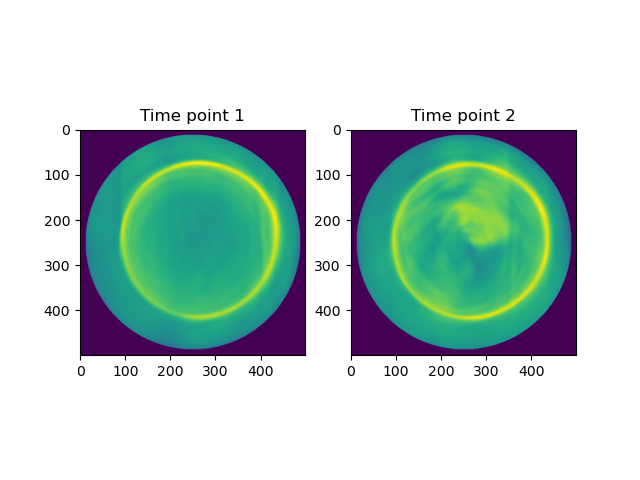

In [8]:
#jupyterlab
#%matplotlib inline
#jupyter notebook
%matplotlib notebook

#Before correction
fig = plt.figure()
ax1 = fig.add_subplot(1, 2, 1)
ax1.set_title('Time point 1')
ax1.imshow(slice_data1[test_slice_no])

#After manual test correction
#fig.subplots_adjust(hspace=.5)
ax2 = fig.add_subplot(1, 2, 2, sharex=ax1, sharey=ax1)
ax2.set_title('Time point 2')
ax2.imshow(slice_data2[test_slice_no])
plt.show()

Saving down toke: 2.99 seconds


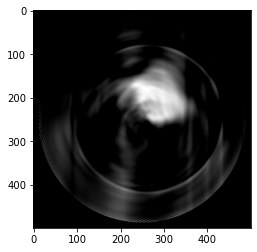

In [9]:
slice_diff = img_as_ubyte(img_as_float32(slice_data2) - img_as_float32(slice_data1))
%matplotlib inline
imshow(slice_diff[test_slice_no], cmap='gray')#, vmin=1, vmax=255)
imp.save_down(slice_path_out, slice_diff, '9_slice_diff')

In [14]:
#mask feature
thres = 31
mask_sample = slice_diff > thres
imp.save_down(slice_path_out, mask_sample, '10_mask')

#masking, inverting mask first, True or False values for 255 or 0
masked_sample = slice_diff * mask_sample
imp.save_down(slice_path_out, masked_sample, '11_masked')

Saving down toke: 1.74 seconds
Saving down toke: 3.49 seconds


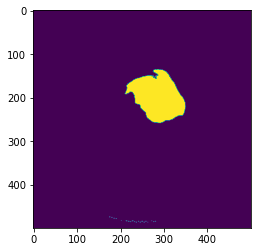

In [15]:
%matplotlib inline
imshow(mask_sample[test_slice_no])

Saving down toke: 1.36 seconds
Saving down toke: 3.2 seconds


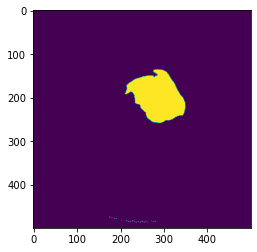

In [16]:
#erode and close and fill holes in 2D

#duplicate stack, to have an extra stack to overwrite
mask_close = mask_sample
no_steps = 1

for i in range(no_steps):
    mask_close = binary_dilation(mask_close, selem=None, out=None)

for i in range(len(slice_diff)):
    mask_close[i] = binary_fill_holes(mask_close[i], structure=disk(3), output=None, origin=0)

#mask_close = util.invert(mask_close)
for i in range(no_steps):
    mask_close = binary_erosion(mask_close, selem=None, out=None)

imp.save_down(slice_path_out, util.invert(mask_close), '12_mask_closed')
imshow(mask_close[test_slice_no])

masked_sample = slice_diff * mask_close
imp.save_down(slice_path_out, masked_sample, '13_masked')

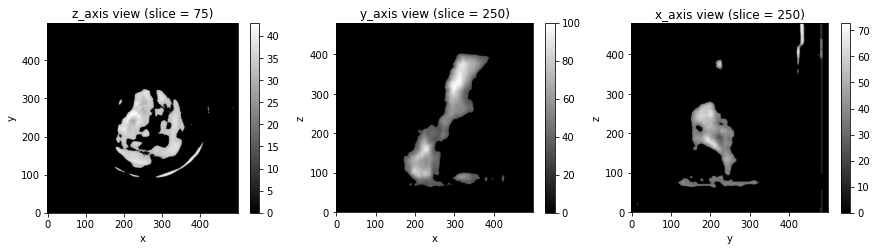

In [17]:
visualization.plot_orthogonal_slices(masked_sample, 75, 250, 250, layout=(1,3))

In [18]:
#batch image processing script

t0 = time.time()

for p in range(10,11):
    t1 = time.time()
    
    #input folder
    data2 = 'rep_' + str(p)
    
    #read in data
    slice_path_in_2 = os.path.join(sample, data2, folder, ind_slice)
    slice_path_out = os.path.join(sample, data2)
    print(slice_path_in_1)
    print(slice_path_in_2)
    print(slice_path_out)

    #read in data
    slice_data2 = ImageCollection(slice_path_in_2)

    #concatenate the data into a 3D-volume
    #read full data set into memory 
    slice_data2 = slice_data2.concatenate()

    #subtract volumes
    slice_diff = img_as_ubyte(img_as_float32(slice_data2) - img_as_float32(slice_data1))
    imp.save_down(slice_path_out, slice_diff, '9_slice_diff')

    #mask feature
    mask_sample = slice_diff > thres
    #imp.save_down(slice_path_out, mask_sample, '10_mask')

    #masking, inverting mask first, True or False values for 255 or 0
    masked_sample = slice_diff * mask_sample
    #imp.save_down(slice_path_out, masked_sample, '11_masked')

    #erode and close and fill holes in 2D

    #duplicate stack, to have an extra stack to overwrite
    mask_close = mask_sample
    no_steps = 1

    for i in range(no_steps):
        mask_close = binary_dilation(mask_close, selem=None, out=None)

    for i in range(len(slice_diff)):
        mask_close[i] = binary_fill_holes(mask_close[i], structure=disk(3), output=None, origin=0)

    #mask_close = util.invert(mask_close)
    for i in range(no_steps):
        mask_close = binary_erosion(mask_close, selem=None, out=None)

    #imp.save_down(slice_path_out, util.invert(mask_close), '12_mask_closed')

    masked_sample = slice_diff * mask_close
    imp.save_down(slice_path_out, masked_sample, '13_masked')

    print('Image processing per sample took: ' + str(round(time.time()-t1,2)) + ' seconds')

print('Entire image processing script for all samples took: ' + str(round(time.time()-t0,2)) + ' seconds')

LavaLamp/rep_1/8_RECON_FULL_rot_center_248.25_8bit/slice*.tiff
LavaLamp/rep_10/8_RECON_FULL_rot_center_248.25_8bit/slice*.tiff
LavaLamp/rep_10
Saving down toke: 2.99 seconds
Saving down toke: 3.04 seconds
Image processing per sample took: 22.78 seconds
Entire image processing script for all samples took: 22.78 seconds


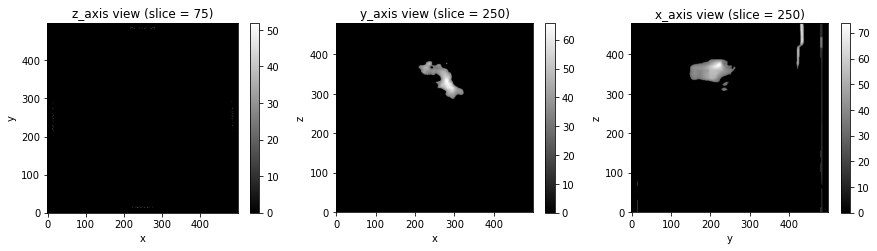

In [19]:
visualization.plot_orthogonal_slices(masked_sample, 75, 250, 250, layout=(1,3))

In [20]:
#segment the glass tube

slice_path_out1 = os.path.join(sample, data1)
print(slice_path_out1)

#mask feature
thres2 = 158
mask_sample = slice_data1 > thres2
imp.save_down(slice_path_out1, mask_sample, '9_mask')

#masking, inverting mask first, True or False values for 255 or 0
masked_sample = slice_data1 * mask_sample
imp.save_down(slice_path_out1, masked_sample, '10_masked')

LavaLamp/rep_1/
Saving down toke: 1.3 seconds
Saving down toke: 3.06 seconds


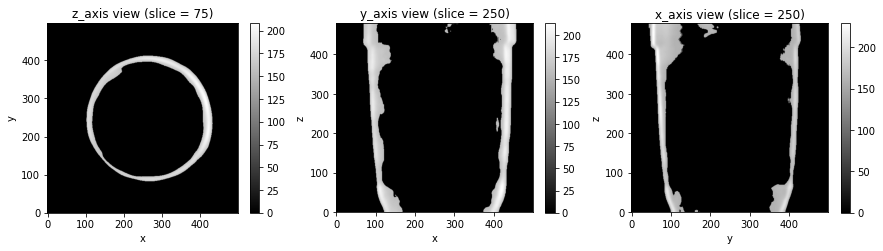

In [21]:
visualization.plot_orthogonal_slices(masked_sample, 75, 250, 250, layout=(1,3))